Guillermo Benito Calviño - 2072106

Sofia Pacheco Garcia - 2070771

Filippo Pra Floriani - 2089902

# Information Theory and Inference - Project
## Missing and spurious interactions and the reconstruction of complex networks

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import networkx as nx
from itertools import product
import random
import time

In [5]:
from functions import *

In [106]:
missing = True     #analyze missing interactions
spurious = False   #analyze spurious interactions

### Theory

In the framework of complex networks, we have to deal with the problem of data reliability. The aim of the project is to to reliably identify false negatives (missing interactions) and false positives (spurious interactions), as well as generate, from a single observed network, a reconstructed network which is closer to the "true" underlying network.

Consider an observed network with adjacency matrix $A^O$; $A^O_{ij} = 1$ if nodes are connected and $0$ otherwise. The observed network is a realization of an underlying network probabilistic model.
Let call $\mathcal{M}$ the set of generative models that could give rise to the observed network, and $p(M|A^O)$ the probability that $M \in \mathcal{M}$ is the model that gave rise to the observation $A^0$. Our best estimate for the probability $p(X = x)$ for an arbitrary property $X$:
$$
p(X = x|A^0) = \int_{\mathcal{M}} dM p(X = x|M)p(M|A^0) 
$$
where $p(X = x|M)$ is the probability that $X = x$ in a network generated with model $M$. Applying Bayes theorem, we obtain:
$$
p(X = x|A^0) = \frac{\int_{\mathcal{M}} dM p(X = x|M)p(A^0|M)p(M)}{\int_{\mathcal{M}} dM' p(A^0|M')p(M') 
}
$$
where $p(A^0|M)$ is the probability that model $M$ gives rise to $A^0$ and $p(M)$ is the a priori probability for model $M$.
We call $p(X = x|A^0)$ the **realiability** of the $X = x$ measurement.



Choose a set of model $\mathcal{M}$. Focus in the family of stochastic block models $\mathcal{M}_{BM}$.
In such a model, nodes are partitioned into groups and the probability that two nodes are connected depends only on the groups to which they belong.

The **reliability of an individual link** is $R^L_{ij} = p_{BM}(A_{ij}=1|A^0)$ that is the probability that the link "truly" exists given our observation fo the whole network.
We obtain:
$$
R^L_{ij} = \frac{1}{Z} \sum_{P \in \mathcal{P}} \left ( \frac{l^0_{\sigma_i \sigma_j} + 1}{r_{\sigma_i \sigma_j} + 2} \right ) exp[-\mathcal{H}(P)]
$$
where
- the sum is over partitions $P$ in the space $\mathcal{P}$ of all possible partitions of the network into groups
- $\sigma_i$ is node $i$'s group in partition $P$
- $l^0_{\alpha \beta}$ is the number of links in the observed network between groups $\alpha$ and $\beta$
- $r_{\alpha \beta}$ is the maximum possible number of links between groups $\alpha$ and $\beta$

The function $\mathcal{H}(P)$ is a function of partition:
$$
\mathcal{H}(P) = \sum_{\alpha \leq \beta} \left [ ln(r_{\alpha \beta} + 1) + ln\binom{r_{\alpha \beta}}{l^0_{\alpha \beta}} \right ]
\quad
,
\quad
Z = \sum_{P \in \mathcal{P}} exp[-\mathcal{H}(P)]
$$


It is not possible to sum over all partitions, therefore, since the mathematical form of $R^L_{ij}$ is the same of an ensemble average, we can use the **Metropolis algorithm** to correctly sample only relevant partitions and obtain an estimate for the link reliability.


### Algorithm scheme

Use the link reliability to identify missing and spurious interactions in network observations. Analyze the performance in 2 datasets: the social network of interactions between people in a karate club and the social network of frequent associations between 62 dolphins.

Consider these 2 datasets as "true" networks $A^T$ and generate hypothetical observations $A^0$ by adding or removing random connections. 
- Missing interactions:

Estimate link realiability $R^L_{ij}$ for each false negative as well as for the true negative. Measure algorithm's accuracy by ranking the reliabilities in decreasing order and calculate the probability that a false negative has a higher ranking than a true negative.

- Spurious interactions:
   
Estimate link realiability $R^L_{ij}$ for each false positve as well as for the true positive. Measure algorithm's accuracy by ranking the reliabilities in decreasing order and calculate the probability that a false positive has a lower ranking than a true positive.

The accuracy is measured using the ROC and AUC.


### Metropolis algorithm

Start by placing each of the $N$ nodes in a group, choosen with uniform probability from a set of $N$ possible groups. Some of the groups will be empty after initial assignment.

At each step, select a random node and move it to a randomly selected group. This update is appropriate sicne it results from an ergodic exploration of the space of partition space of possible partitions and it satisfies detailed balance.

Accept the move scheme:
- if $\Delta \mathcal{H} \leq 0$, the change is automatically accepted
- otherwise accept the change with probability $exp(-\Delta \mathcal{H})$

Set a burn-in period and sample many partitions after a thinning procedure. Evaluate the burn-in and thinning based respectively on the equilibration period of $\mathcal{H}$ and on the autocorrelation of the samples, measured with the mutual information between partitions.

### Code approach

Define a network as a vector whose indexes are the nodes' labels and the values are the block/group to which they belongs:
<div>
<img src=immm.jpeg width="400"/>
</div>

# (A) ACCURACY OF LINK RELIABILITY

## 1) Social network of interactions between people in a karate club:

##### Set Metropolis algorithm and define burn-in and thinning:

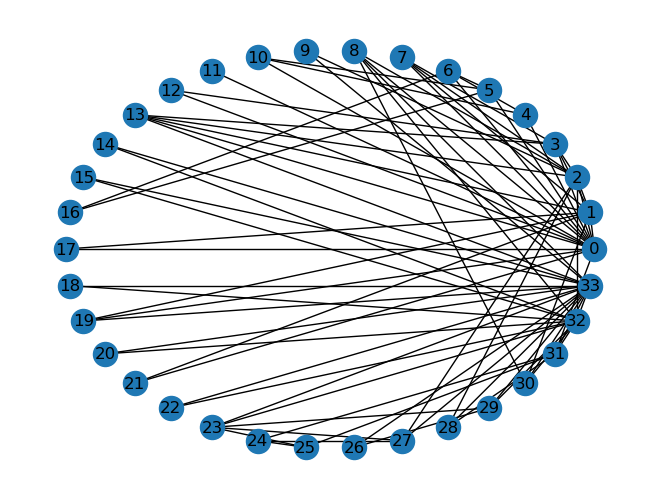

In [81]:
G = nx.karate_club_graph()

nx.draw_circular(G, with_labels=True)
plt.show()

In [82]:
N = len(G.nodes)
links = list(G.edges)

if missing:
    links_obs = remove_links(links, 0.3)
if spurious:
    links_obs = add_links(N, links, 0.3)

In [ ]:
max_step = 500_000

chain = metropolis(N, links_obs, max_step)
R_ = R_vector(chain, links_obs, G)
roc_auc_score(R_[0], R_[1])

In [ ]:
plt.plot(chain[1])
plt.xlabel('Time', fontsize = 15)
plt.ylabel('exp(-H+250)', fontsize = 15)
plt.yscale('log')
plt.show()

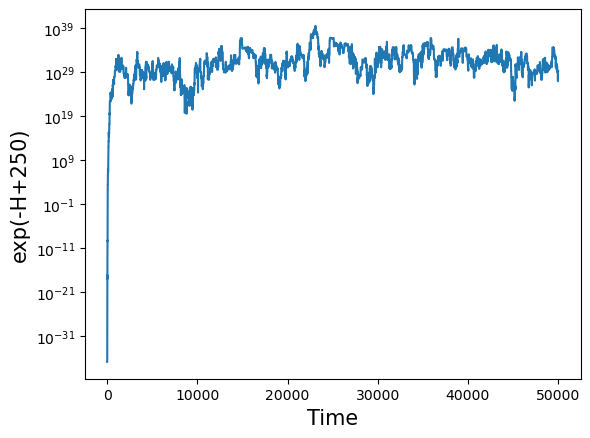

In [ ]:
n_burn_in = 10_000
mut_info = mutual_info(chain, T = (max_step-1), initial = n_burn_in, plot = False)

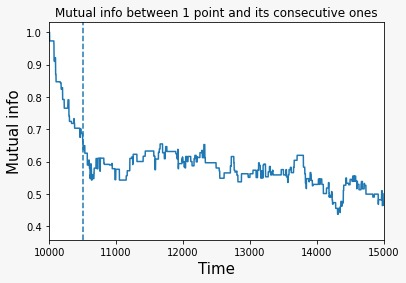

Burn-in required $\sim 10000$ and thinning $\sim 500$ for both missing and spurious interactions.

##### Results:

In [ ]:
f_list = np.arange(0, 1, 0.1)
acc_mis, acc_sp = results_accuracy(G, max_step, f_list, n_burn_in = n_burn_in, thinning = thinning, plot = True)

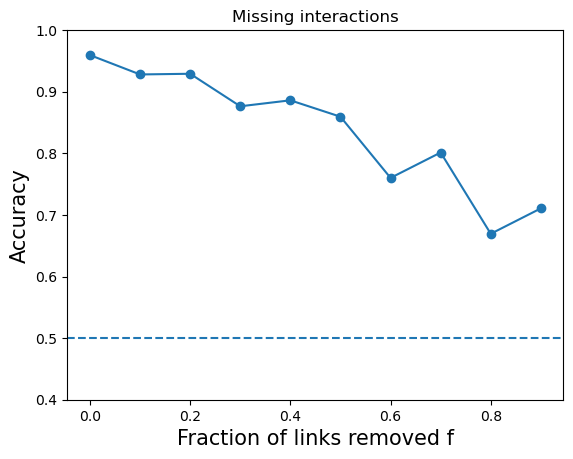

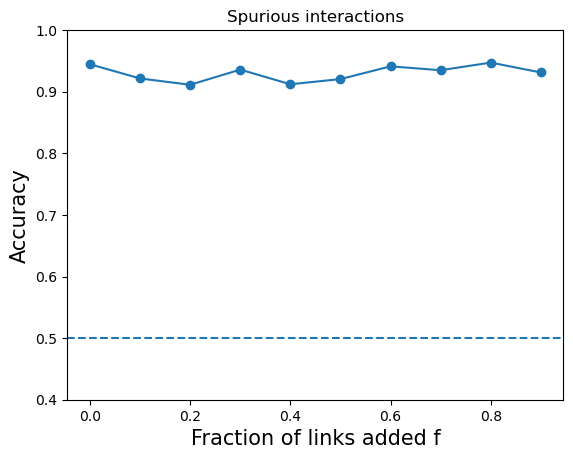

In [34]:
plt.plot(f_list, acc_mis, marker = 'o')
plt.xlabel('Fraction of links removed f', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim((0.4,1))
plt.axhline(y=0.5, linestyle='--')
plt.title('Missing interactions')
plt.show()

plt.plot(f_list, acc_sp, marker = 'o')
plt.xlabel('Fraction of links added f', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim((0.4,1))
plt.axhline(y=0.5, linestyle='--')
plt.title('Spurious interactions')
plt.show()

## 2) Social network of frequent associations between 62 dolphins:

##### Set Metropolis algorithm and define burn-in and thinning:

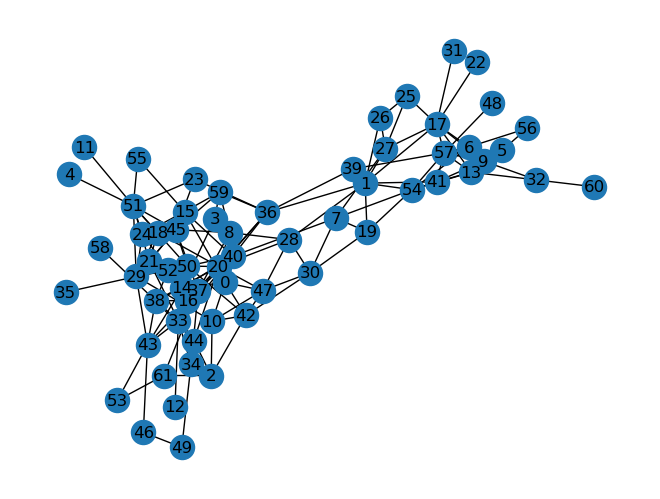

In [79]:
file_path = 'dolphins.gml'
G = nx.read_gml(file_path)
G = nx.convert_node_labels_to_integers(G)

nx.draw(G, with_labels = True)
plt.show()

In [ ]:
N = len(G.nodes)
links = list(G.edges)

if missing:
    links_obs = remove_links(links, 0.3)
if spurious:
    links_obs = add_links(N, links, 0.3)

In [ ]:
max_step = 50_000

chain = metropolis(N, links_obs, max_step)
R_ = R_vector(chain, links_obs, G)
roc_auc_score(R_[0], R_[1])

In [ ]:
plt.plot(chain[1])
plt.xlabel('Time', fontsize = 15)
plt.ylabel('exp(-H+250)', fontsize = 15)
plt.yscale('log')
plt.show()

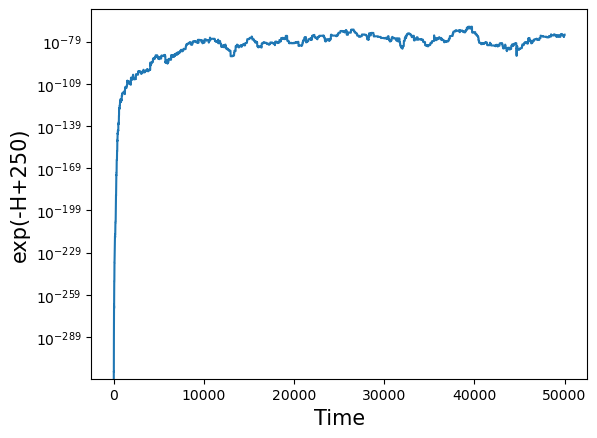

In [ ]:
n_burn_in = 15000
mut_info = mutual_info(chain, T = (max_step-1), initial = n_burn_in, plot = True)

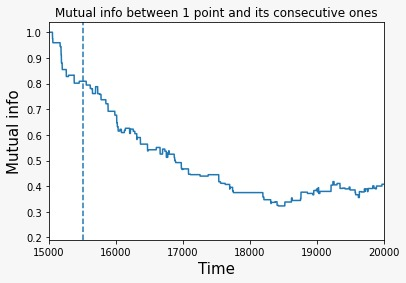

Burn-in required $\sim 1500$ and thinning $\sim 500$ for both missing and spurious interactions.

##### Results:

In [ ]:
f_list = np.arange(0, 1, 0.1)
max_step = 500_000

acc_mis, acc_sp = results_accuracy(G, max_step, f_list, n_burn_in = n_burn_in, thinning = thinning, plot = True)

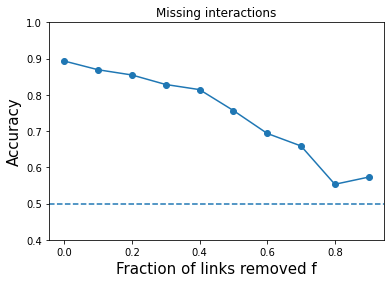

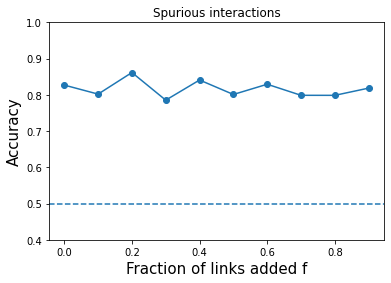

# (B) RECONSTRUCTION

### 0. Theoretic explanation:

The success at detecting both missing and spurious interactions confirms that the used approach is able to uncover the structural features of the true network $A^T$. 
- But, __is it possible to 'reconstruct' the observation $A^O$ to gain greater insight into the global structure of $A^T$?__
- This is tricky: we have the handickup of not knowing, a priori, how many missing and supurious interactions there are.

First step toward network reconstruction is to obtain __network reliability__:
$$R_A^N \equiv p_{BM}(A|A^O)$$
(probability that $A$ is the true network given our observation $A^O$).

It is computed as follows:

$$
R_A^N=\frac{1}{Z} \sum_{P \in \mathcal{P}} h\left(A ; A^O, P\right) \exp [-\mathcal{H}(P)]
$$
where

$$
h\left(A ; A^O, P\right)=\exp \left\{\sum_{\alpha \leq \beta}\left[\ln \left(\frac{r_{\alpha \beta}+1}{2 r_{\alpha \beta}+1}\right)+\ln \left(\frac{\left(\begin{array}{c}
r_{\alpha \beta} \\
o \beta
\end{array}\right)}{\left(l_{\alpha \beta}+l_{\alpha \beta}^O\right)}\right)\right]\right\}
$$

- the sum is over partitions $P$ in the space $\mathcal{P}$ of all possible partitions of the network into groups
- $l^O_{\alpha \beta}$ is the number of links in the observed network between groups $\alpha$ and $\beta$
- $r_{\alpha \beta}$ is the maximum possible number of links between groups $\alpha$ and $\beta$
- $l_{\alpha \beta}$ is the number of links in network $A$ between groups $\alpha$ and $\beta$

Given the network reliability  $R_A^N = p_{BM}(A|A^O)$, the expected value of a property $X$ over all possible networks $A$ is a better estimate of $X(A^T)$ than $X(A^O)$:

$$\langle X\rangle = \sum_A X(A) R_A^N$$

We find that in many situations $R_{A^T}^N \gg R_{A^O}^N$, which means that given an inaccurate observation $A^O$, our approach is able to identify that $A^T$ is a more likely network than $A^O$. This confirms that even without knowing A^T, it is possible to estimate a property $X(A^T)$ better than just by measuring that property on $A^O$. 

Summing over all possible networks is not possible, so we __use the approximation $\langle X\rangle \approx X(A^R)$__.
- $A^R$ (network reconstruction) is the network that maximizes $R_A^N$ $\rightarrow$ maximum a posteriori estimate of A.
- $X(A^R)$ is a better estimate of $X(A^T)$ than $X(A^O)$.

__We will build reconstructions by heuristically maximizing $R_A^N$, starting from $A^O$.__

#### *Heuristic Network Reconstruction:*

__GOAL:__ find $A^R = argmax_A R_A^N$ avoiding the exhaustive maximization of $R_A^N$.

- Evaluate link reliabilities $R_{ij}^L$ for all pairs of nodes in $A^O$.
- Sort observed links ($A_{ij}^O = 1 $) by increasing reliability.
- Sort observed non-links ($A_{ij}^O = 0$) by decreasing reliability.
- Choose pairs of link/non-link in order.
- Remove the link (with lowest reliability) and Add the non-link (with highest reliability).
- Accept the change IFF $R_A^N$ increases.
- Repeat procedure going down the lists until five consecutive attempts to swap a link/non-link pair are rejected.
- Then reevaluate $R_{ij}^L$ and repeat the process until no link swaps are accepted.

#### Reconstruction computation

In [6]:
G = nx.karate_club_graph()
N = len(G.nodes)
links = list(G.edges)

In [ ]:
adj_obs_list, best_A_list, max_value_list, p_list, bad_links_list = reconstruction_errors(N, G, links)

In [86]:
adj_obs_list = np.load('adj_obs_list.npy')
adj_rec_list = np.load('best_A_list.npy')
max_value_list = np.load('max_value_list.npy')
p_list = np.load('p_list.npy')
bad_links_list = np.load('bad_links_list.npy')

### 1. Error rate comparisson for Observed and Reconstructed network

In [ ]:
G_adj = nx.to_numpy_array(G)
G_adj[G_adj!=0]=1

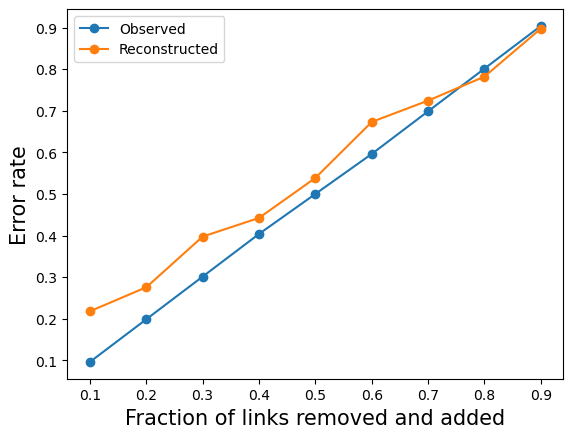

In [112]:
error = np.arange(0.1,1,0.1)
error_rate_obs_list = []
error_rate_rec_list = []
for i in range(len(error)):    
    error_rate_obs = np.sum(np.abs(G_adj-adj_obs_list[i]))/(len(links))/4
    error_rate_rec = np.sum(np.abs(G_adj-adj_rec_list[i]))/(len(links))/4
    
    error_rate_obs_list.append(error_rate_obs)
    error_rate_rec_list.append(error_rate_rec)

plt.plot(error, error_rate_obs_list, marker = 'o',label = 'Observed')
plt.plot(error, error_rate_rec_list, marker = 'o',label = 'Reconstructed')
plt.xlabel('Fraction of links removed and added', fontsize = 15)
plt.ylabel('Error rate', fontsize = 15)
plt.legend()

plt.show()

### 2. Network properties comparisson  between Observed and Reconstructed network

__Clustering__: The clustering coefficient for the graph is the average,
$$
C=\frac{1}{n} \sum_{v \in G} c_v,
$$
where $n$ is the number of nodes in $\mathbf{G}$.

__Betweenness__: Compute the shortest-path betweenness centrality for nodes.
Betweenness centrality of a node $v$ is the sum of the fraction of all-pairs shortest paths that pass through $v$ :
$$
c_B(v)=\sum_{s, t \in V} \frac{\sigma(s, t \mid v)}{\sigma(s, t)}
$$
where $V$ is the set of nodes, $\sigma(s, t)$ is the number of shortest $(s, t)$-paths, and $\sigma(s, t \mid v)$ is the number of those paths passing through some node $v$ other than $s$, $t$. If $s=t, \sigma(s, t)=1$, and if $v \in s, t, \sigma(s, t \mid v)=0^{[2]}$.

__Effective Size__: The effective size of a node's ego network is based on the concept of redundancy. A person's ego network has redundancy to the extent that her contacts are connected to each other as well. The nonredundant part of a person's relationships is the effective size of her ego network [1]. Formally, the effective size of a node $u$, denoted $e(u)$, is defined by
$$
e(u)=\sum_{v \in N(u) \backslash\{u\}}\left(1-\sum_{w \in N(v)} p_{u w} m_{v w}\right)
$$
where $N(u)$ is the set of neighbors of $u$ and $p_{u w}$ is the normalized mutual weight of the (directed or undirected) edges joining $u$ and $v$, for each vertex $u$ and $v$ [1]. And $m_{v w}$ is the mutual weight of $v$ and $w$ divided by $v$ highest mutual weight with any of its neighbors. The mutual weight of $u$ and $v$ is the sum of the weights of edges joining them (edge weights are assumed to be one if the graph is unweighted).

__Assortativity__: Compute degree assortativity of graph.

Assortativity measures the similarity of connections in the graph with respect to the node degree.

In [12]:
clus_obs, clus_rec, bt_obs, bt_rec, es_obs, es_rec, ass_obs, ass_rec = graph_properties(G, adj_obs_list, best_A_list)

In [15]:
clus_obs = np.load('clus_obs.npy')
clus_rec = np.load('clus_rec.npy')
bt_obs = np.load('bt_obs.npy')
bt_rec = np.load('bt_rec.npy')
es_obs = np.load('es_obs.npy')
es_rec = np.load('es_rec.npy')
ass_obs = np.load('ass_obs.npy')
ass_rec = np.load('ass_rec.npy')

In [ ]:
properties_plots(clus_obs, clus_rec, bt_obs, bt_rec, es_obs, es_rec, ass_obs, ass_rec)

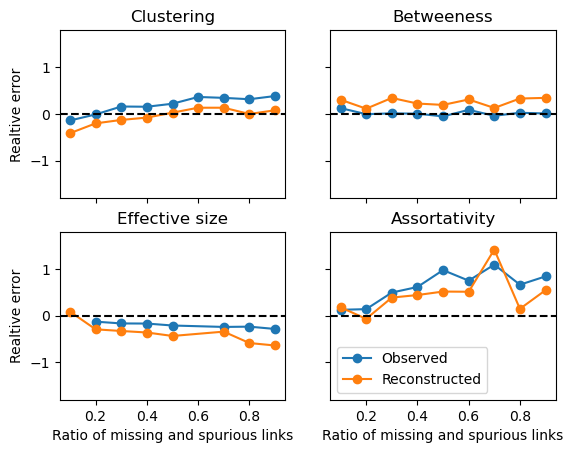